# LightGBM
## Import Libraries

In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [2]:
from Utils import plot_corrlation_heatmap, plot_mi_heatmap
from FeatureSelectionUtils import compute_permutation_importance, plot_feature_importance, export_final_selected_features_to_csv

In [3]:
# Set up a dataframe to store the results from different versions
train_metrics_lgbm = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics_lgbm = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Import Train and Test Datasets

In [4]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [5]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Version": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Version": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In this notebook, we will explore LightGBM. It is another gradient boosting framework that is designed for efficiency and speed. It uses a novel tree-based learning algorithm that splits the tree leaf-wise instead of level-wise, which reduces the number of nodes to be split and leads to faster training times. LightGBM also supports features like categorical feature optimization and parallel training.

The model will first be trained with all available features on the default setting, then apply feature selection method to select the optimal set of features, and perform hyperparameter tuning. The performance of the model in each stage will be observed and compared.

## Build the Baseline Model before Feature Engineering

In [6]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

In [7]:
X_train_basic = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test_basic = pd.read_csv('Data/X_test.csv')[columns]

print("Train Set :", Y_train.shape, X_train_basic.shape)
print("Test Set  :", Y_test.shape, X_test_basic.shape)

Train Set : (20392, 1) (20392, 39)
Test Set  : (8176, 1) (8176, 39)


In [114]:
lgbm_basic = LGBMClassifier(random_state=47).fit(X_train_basic, Y_train.values.ravel())

In [115]:
# Predict the output based on our training and testing dataset
Y_train_pred_basic = lgbm_basic.predict(X_train_basic)
Y_test_pred_basic = lgbm_basic.predict(X_test_basic)

In [116]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Baseline before Feature Engineering", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8985876814437034
Precision 	: 0.9121703853955375
Recall 		: 0.8821106316202433
F1 Score 	: 0.8968887116074991

**Test Set Metrics**
Accuracy 	: 0.8280332681017613
Precision 	: 0.6339805825242718
Recall 		: 0.3882282996432818
F1 Score 	: 0.48156342182890854


## Build the Baseline Model after Feature Engineering

In [6]:
lgbm = LGBMClassifier(random_state=47).fit(X_train, Y_train.values.ravel())

In [118]:
# Predict the output based on our training and testing dataset
Y_train_pred = lgbm.predict(X_train)
Y_test_pred = lgbm.predict(X_test)

In [119]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, "Baseline after Feature Engineering", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8921635935661043
Precision 	: 0.9090537084398977
Recall 		: 0.8715182424480188
F1 Score 	: 0.8898903409944419

**Test Set Metrics**
Accuracy 	: 0.8226516634050881
Precision 	: 0.5780619111709286
Recall 		: 0.5107015457788348
F1 Score 	: 0.5422979797979798


## Eliminate the Features with permutation_importance=0

In [7]:
feature_importances, feature_names = compute_permutation_importance(lgbm, X_train, Y_train)

In [8]:
# Remove features with permutation_importance=0
feature_names = feature_names[feature_importances>0]
feature_importances = feature_importances[feature_importances>0]

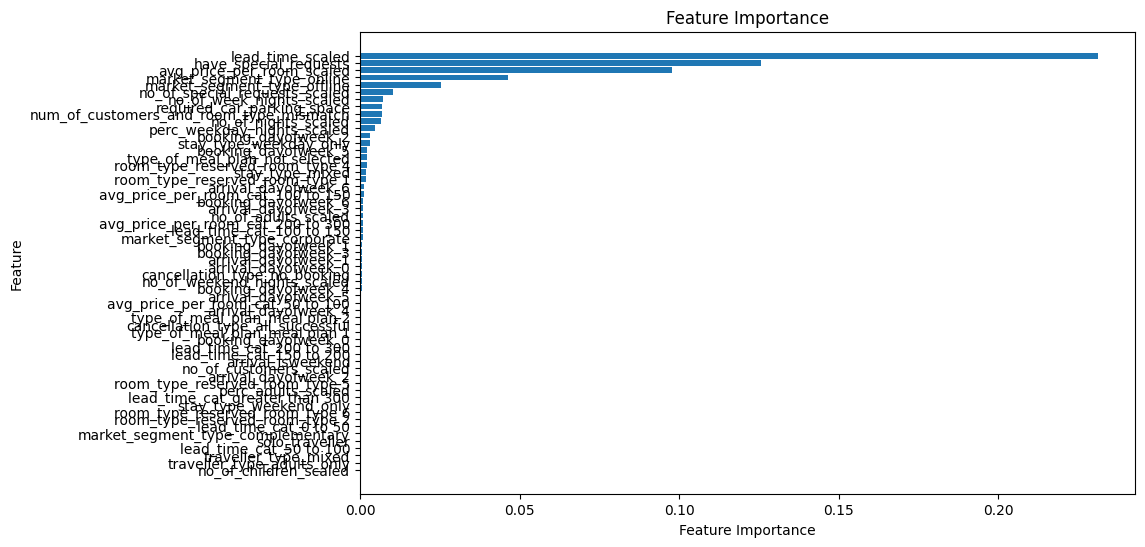

In [9]:
# Visualize permutation_importance
plot_feature_importance(feature_importances, feature_names)

In [10]:
selected_columns = feature_names

## Fit the Model again with the selected set of features

In [11]:
lgbm_selected = LGBMClassifier(random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

In [121]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected = lgbm_selected.predict(X_train[selected_columns])
Y_test_pred_selected = lgbm_selected.predict(X_test[selected_columns])

In [122]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Feature Selected", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.892114554727344
Precision 	: 0.9089607201309329
Recall 		: 0.8715182424480188
F1 Score 	: 0.8898457840977368

**Test Set Metrics**
Accuracy 	: 0.8264432485322897
Precision 	: 0.5925404644616468
Recall 		: 0.5005945303210464
F1 Score 	: 0.5427006123106671


## Eliminate Features with low in-built feature importance

In [12]:
# Get feature importance score
feature_importances = lgbm_selected.feature_importances_
# Get feature names
feature_names = selected_columns

# Remove features with feature_importances<=30
feature_names = feature_names[feature_importances>30]
feature_importances = feature_importances[feature_importances>30]

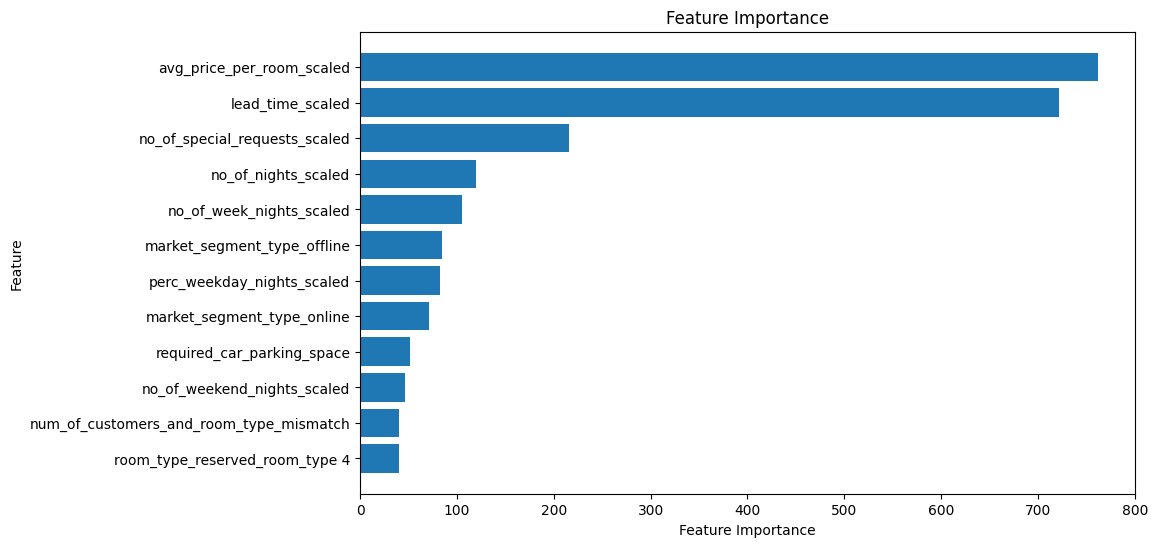

In [13]:
# Get indices that would sort feature importances
sorted_indices = np.argsort(feature_importances)
# Visualize permutation_importance
plot_feature_importance(feature_importances[sorted_indices], feature_names[sorted_indices])


Besides, there are some highly correlated columns, and we will remove one of them that contributes less to the model.

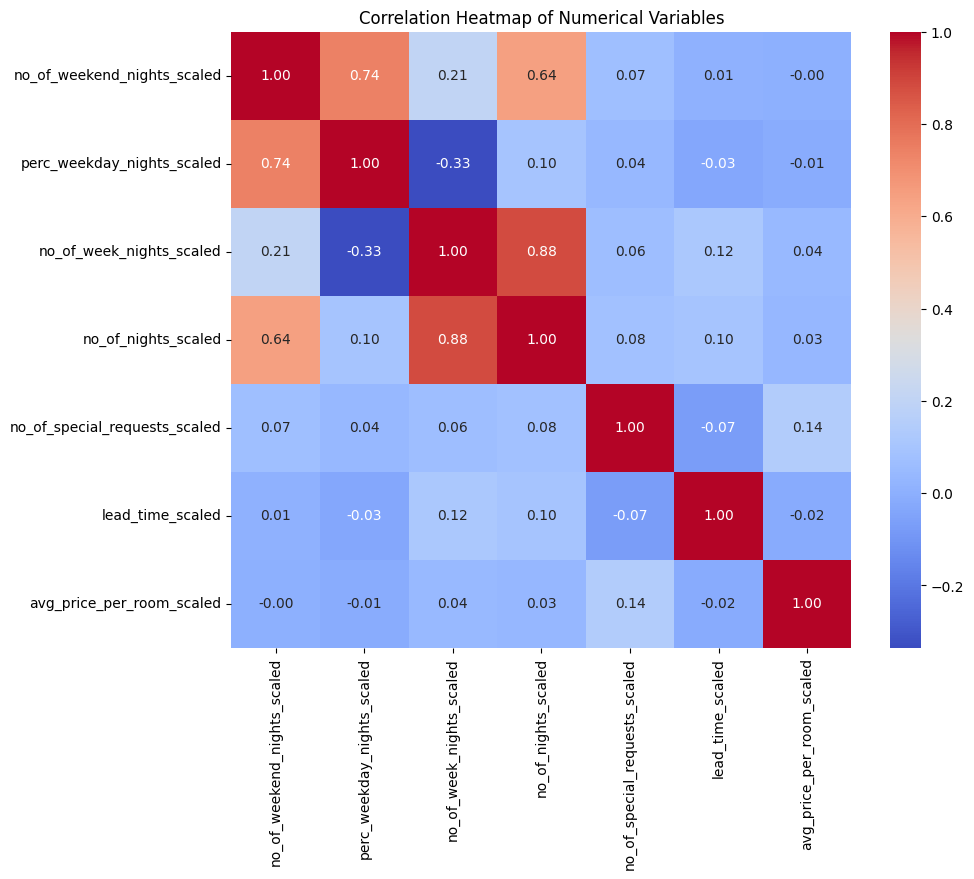

In [55]:
num_cols = [x for x in feature_names[sorted_indices] if '_scaled' in x]
plot_corrlation_heatmap(X_train[num_cols])

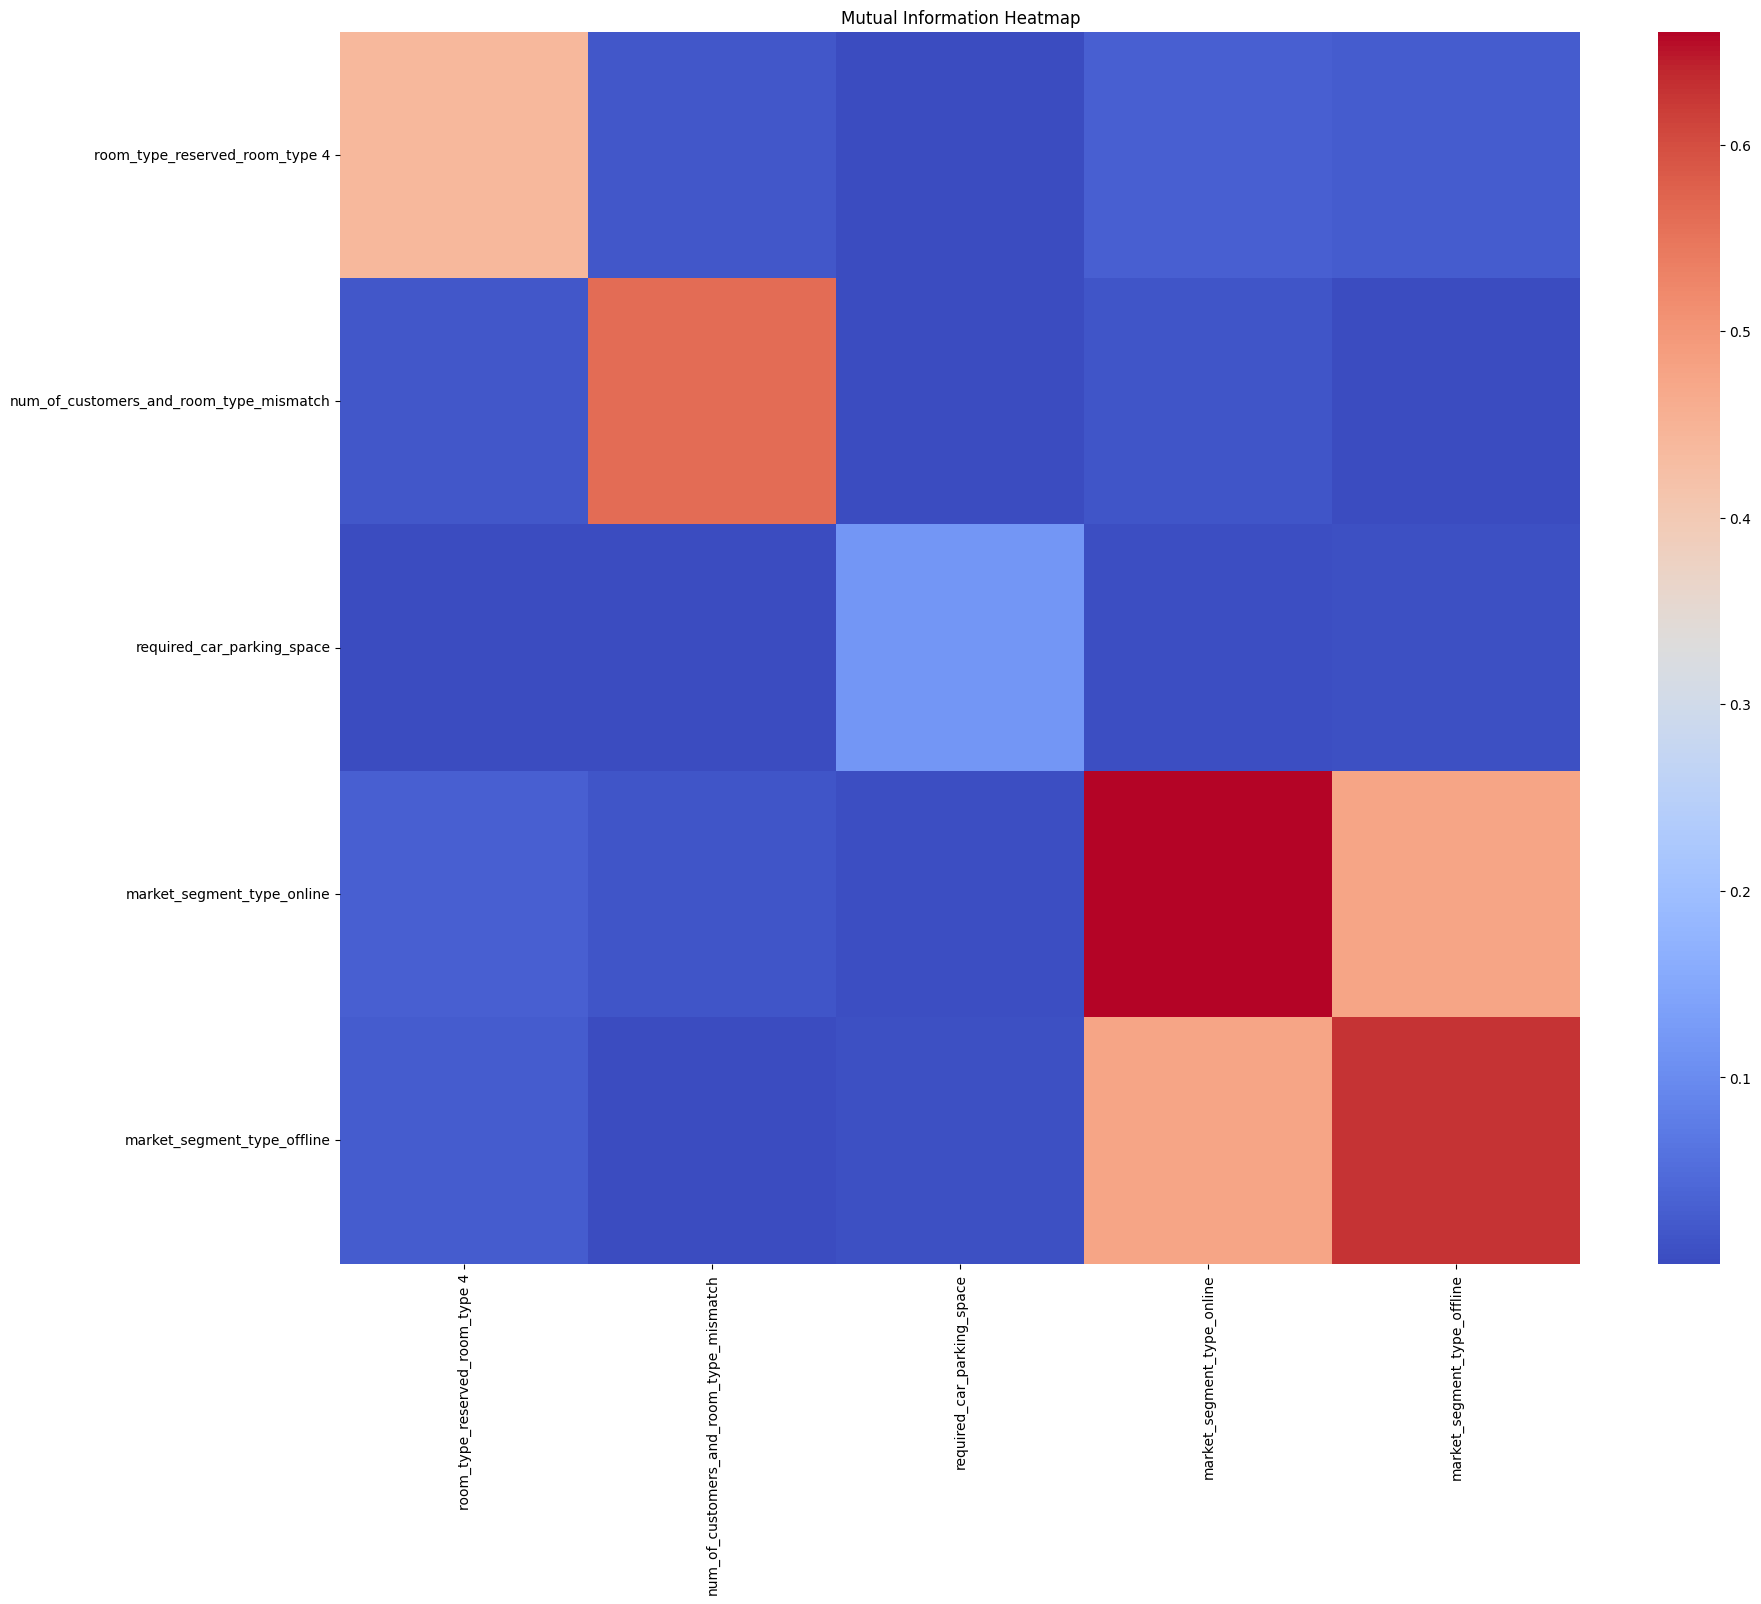

In [56]:
cat_cols = [x for x in feature_names[sorted_indices] if x not in num_cols]
plot_mi_heatmap(X_train[cat_cols])

Based on the observations, 'no_of_nights_scaled', 'no_of_week_nights_scaled', 'market_segment_type_offline' will be removed.

In [14]:
to_remove = ['no_of_nights_scaled', 'no_of_week_nights_scaled', 'market_segment_type_offline']
final_columns = [x for x in feature_names[sorted_indices] if x not in to_remove]

## Fit the model with the final set of features

In [123]:
lgbm_selected_final = LGBMClassifier(random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [124]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected_final = lgbm_selected_final.predict(X_train[final_columns])
Y_test_pred_selected_final = lgbm_selected_final.predict(X_test[final_columns])

In [125]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected_final, Y_test, Y_test_pred_selected_final, "Final Feature Selected", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8846606512357787
Precision 	: 0.9028348397699261
Recall 		: 0.8621027854060416
F1 Score 	: 0.8819987959060807

**Test Set Metrics**
Accuracy 	: 0.8265655577299413
Precision 	: 0.5891891891891892
Recall 		: 0.5184304399524375
F1 Score 	: 0.551549652118912


## Hyperparameter Tuning

For LightGBM, there are several hyperparameters to tune:
1. num_leaves (default=31): Maximum tree leaves for base learners controls the maximum number of leaves in each tree. Higher values can increase model complexity but may also lead to overfitting.
2. max_depth (default=-1): Maximum depth of tree. Deeper trees can capture more complex patterns in the data but may also lead to overfitting.
3. learning_rate (default=0.1): Learning rate determines the step size at each iteration while moving towards a minimum of the loss function. Lower values require more iterations but can lead to better convergence.
4. min_split_gain (default=0): Minimum loss reduction required to make a further partition on a leaf node of the tree. Increasing this value can help prevent overfitting.
5. colsample_bytree (default=1): Fraction of features (columns) used for training each tree. This can be used to introduce randomness and reduce overfitting.
6. reg_lambda (default=0): L2 regularization term on weights. This penalty term helps prevent overfitting by discouraging large weights.

### Tune num_leaves

In [70]:
parameters_num_leaves = {
    'num_leaves': range(20, 80, 10),
    }
model = LGBMClassifier(random_state=47)
grid_search_num_leaves = GridSearchCV(model, param_grid=parameters_num_leaves, cv=5, scoring='f1', verbose=1)
grid_search_num_leaves.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=47),
             param_grid={'num_leaves': range(20, 80, 10)}, scoring='f1',
             verbose=1)

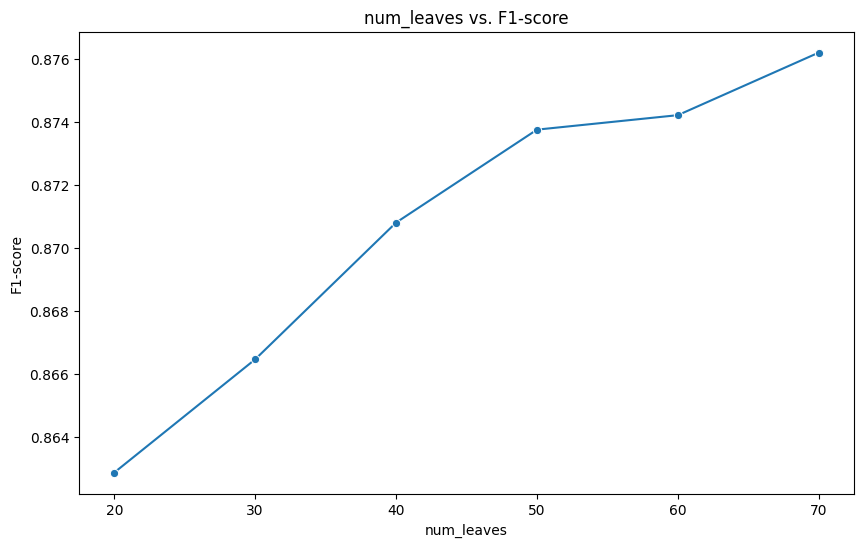

In [71]:
plt.figure(figsize=(10, 6))

# Plotting num_leaves vs. f1
sns.lineplot(x=list(range(20, 80, 10)), y=grid_search_num_leaves.cv_results_['mean_test_score'], marker='o')
plt.title('num_leaves vs. F1-score')
plt.xlabel('num_leaves')
plt.ylabel('F1-score')
plt.show()

While the model performance keeps increasing as the number of leaves increases, to prevent overfitting, we will adopt the num_leaves=45.

### Tune max_depth

In [75]:
parameters_max_depth = {
    'max_depth': range(3, 10, 1),
    }
model = LGBMClassifier(num_leaves=45, random_state=47)
grid_search_max_depth = GridSearchCV(model, param_grid=parameters_max_depth, cv=5, scoring='f1', verbose=1)
grid_search_max_depth.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(num_leaves=45, random_state=47),
             param_grid={'max_depth': range(3, 10)}, scoring='f1', verbose=1)

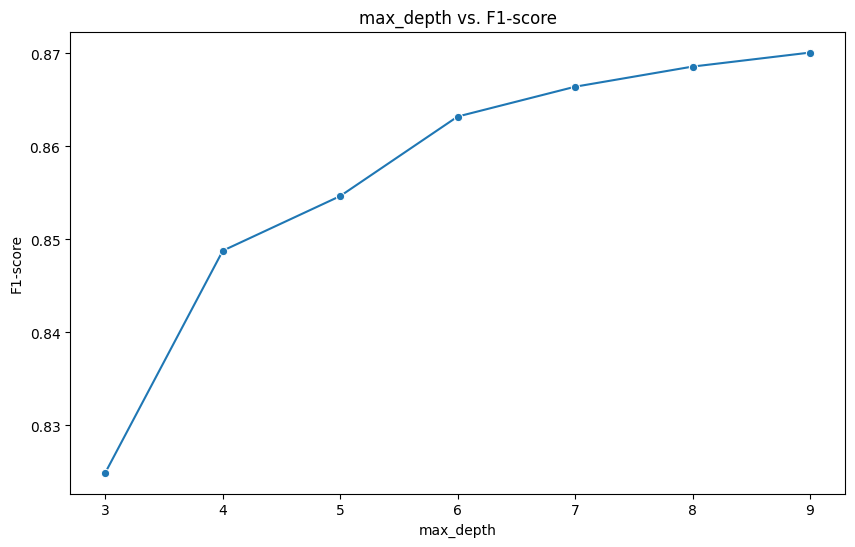

In [76]:
plt.figure(figsize=(10, 6))

# Plotting max_depth vs. f1
sns.lineplot(x=list(range(3, 10, 1)), y=grid_search_max_depth.cv_results_['mean_test_score'], marker='o')
plt.title('max_depth vs. F1-score')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.show()

max_depth=6 provides the optimal performance, as after that the improvement is much subtle.

### Tune learning_rate

In [77]:
parameters_learning_rate = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    }
model = LGBMClassifier(num_leaves=45, max_depth=6, random_state=47)
grid_search_learning_rate = GridSearchCV(model, param_grid=parameters_learning_rate, cv=5, scoring='f1', verbose=1)
grid_search_learning_rate.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, num_leaves=45,
                                      random_state=47),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5]},
             scoring='f1', verbose=1)

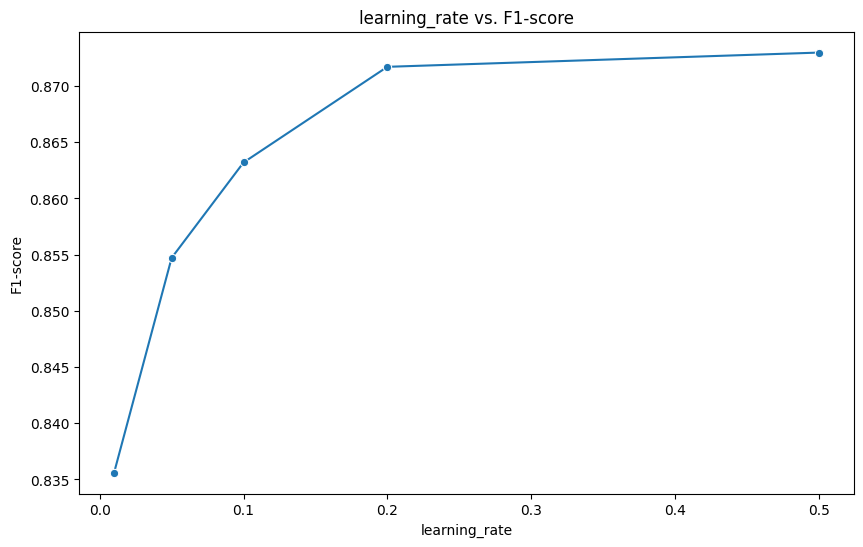

In [78]:
plt.figure(figsize=(10, 6))

# Plotting learning_rate vs. f1
sns.lineplot(x=[0.01, 0.05, 0.1, 0.2, 0.5], y=grid_search_learning_rate.cv_results_['mean_test_score'], marker='o')
plt.title('learning_rate vs. F1-score')
plt.xlabel('learning_rate')
plt.ylabel('F1-score')
plt.show()

The default value learning_rate=0.1 gives the optimal performance.

### Tune min_split_gain

In [79]:
parameters_min_split_gain = {
    'min_split_gain': [0, 0.1, 0.2, 0.5, 1]
    }
model = LGBMClassifier(num_leaves=45, max_depth=6, learning_rate=0.1, random_state=47)
grid_search_min_split_gain = GridSearchCV(model, param_grid=parameters_min_split_gain, cv=5, scoring='f1', verbose=1)
grid_search_min_split_gain.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, num_leaves=45,
                                      random_state=47),
             param_grid={'min_split_gain': [0, 0.1, 0.2, 0.5, 1]}, scoring='f1',
             verbose=1)

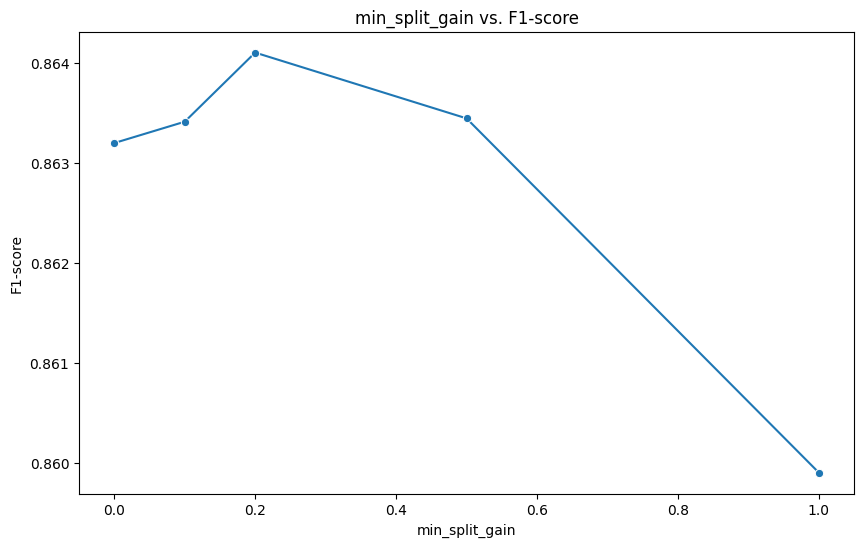

In [80]:
plt.figure(figsize=(10, 6))

# Plotting min_split_gain vs. f1
sns.lineplot(x=[0, 0.1, 0.2, 0.5, 1], y=grid_search_min_split_gain.cv_results_['mean_test_score'], marker='o')
plt.title('min_split_gain vs. F1-score')
plt.xlabel('min_split_gain')
plt.ylabel('F1-score')
plt.show()

min_split_gain=0.2 provides the best performance.

### Tune colsample_bytree

In [83]:
parameters_colsample = {
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
model = LGBMClassifier(num_leaves=45, max_depth=6, learning_rate=0.1, min_split_gain=0.2, random_state=47)
grid_search_colsample = GridSearchCV(model, param_grid=parameters_colsample, cv=5, scoring='f1', verbose=1)
grid_search_colsample.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, min_split_gain=0.2,
                                      num_leaves=45, random_state=47),
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             scoring='f1', verbose=1)

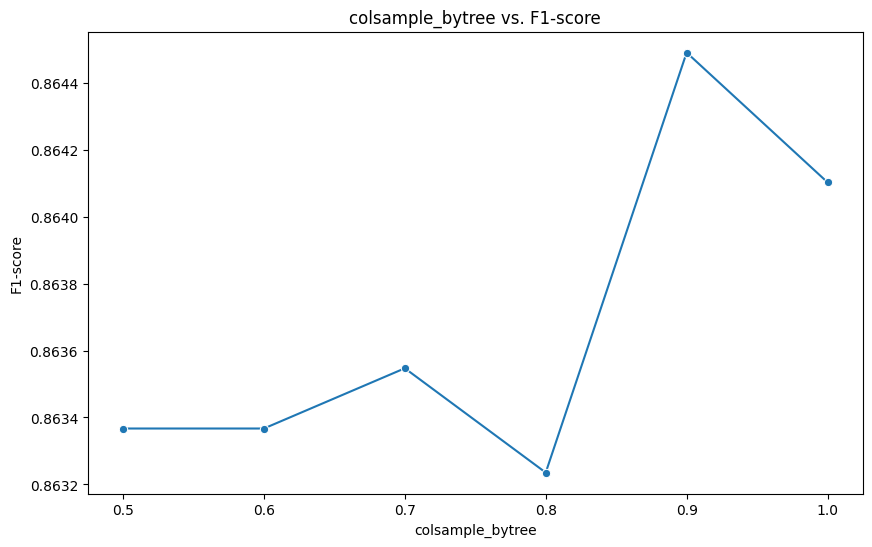

In [84]:
plt.figure(figsize=(10, 6))

# Plotting colsample_bytree vs. f1
sns.lineplot(x=[0.5, 0.6, 0.7, 0.8, 0.9, 1], y=grid_search_colsample.cv_results_['mean_test_score'], marker='o')
plt.title('colsample_bytree vs. F1-score')
plt.xlabel('colsample_bytree')
plt.ylabel('F1-score')
plt.show()

Performance variation introduced by colsample_bytree is not significant, so we will keep the default value colsample_bytree=1.

### Tune reg_lambda

In [85]:
parameters_reg = {
    'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5, 3]
    }
model = LGBMClassifier(num_leaves=45, max_depth=6, learning_rate=0.1, min_split_gain=0.2, random_state=47)
grid_search_reg = GridSearchCV(model, param_grid=parameters_reg, cv=5, scoring='f1', verbose=1)
grid_search_reg.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=6, min_split_gain=0.2,
                                      num_leaves=45, random_state=47),
             param_grid={'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5, 3]},
             scoring='f1', verbose=1)

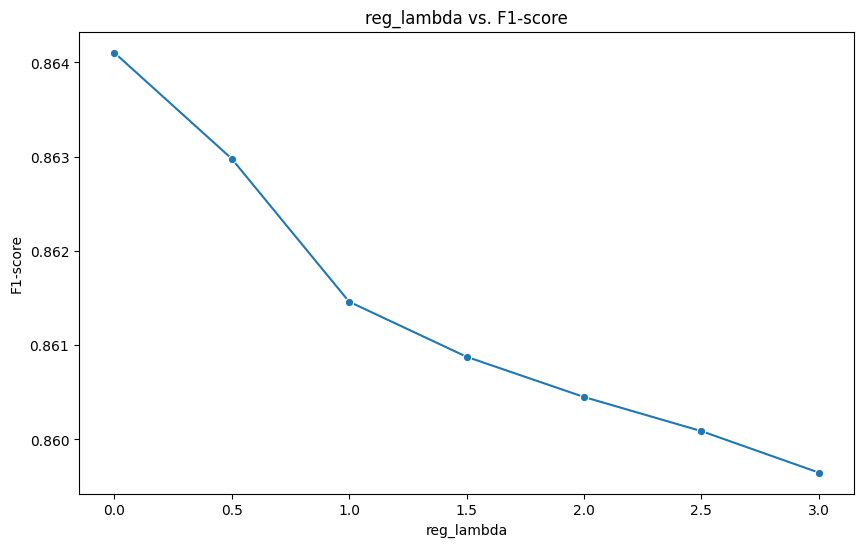

In [86]:
plt.figure(figsize=(10, 6))

# Plotting reg_lambda vs. f1
sns.lineplot(x=[0, 0.5, 1, 1.5, 2, 2.5, 3], y=grid_search_reg.cv_results_['mean_test_score'], marker='o')
plt.title('reg_lambda vs. F1-score')
plt.xlabel('reg_lambda')
plt.ylabel('F1-score')
plt.show()

While introducing regularization will reduce the f1 score for training set, to reduce overfitting, we will set reg_lambda=2.

## Fit the Model again the tuned hyperparameters

In [15]:
lgbm_tuned = LGBMClassifier(num_leaves=45, max_depth=6, learning_rate=0.1, min_split_gain=0.2, reg_lambda=3).fit(X_train[final_columns], Y_train.values.ravel())

In [127]:
# Predict the output based on our training and testing dataset
Y_train_pred_tuned = lgbm_tuned.predict(X_train[final_columns])
Y_test_pred_tuned = lgbm_tuned.predict(X_test[final_columns])

In [128]:
train_metrics_lgbm, test_metrics_lgbm = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "Hyperparameter Tuned", train_metrics_lgbm, test_metrics_lgbm)

**Training Set Metrics**
Accuracy 	: 0.8730874852883483
Precision 	: 0.8925696594427245
Recall 		: 0.8482738328756375
F1 Score 	: 0.8698581916926482

**Test Set Metrics**
Accuracy 	: 0.8293786692759295
Precision 	: 0.5988973121984839
Recall 		: 0.5166468489892985
F1 Score 	: 0.5547398659431855


## Evaluation

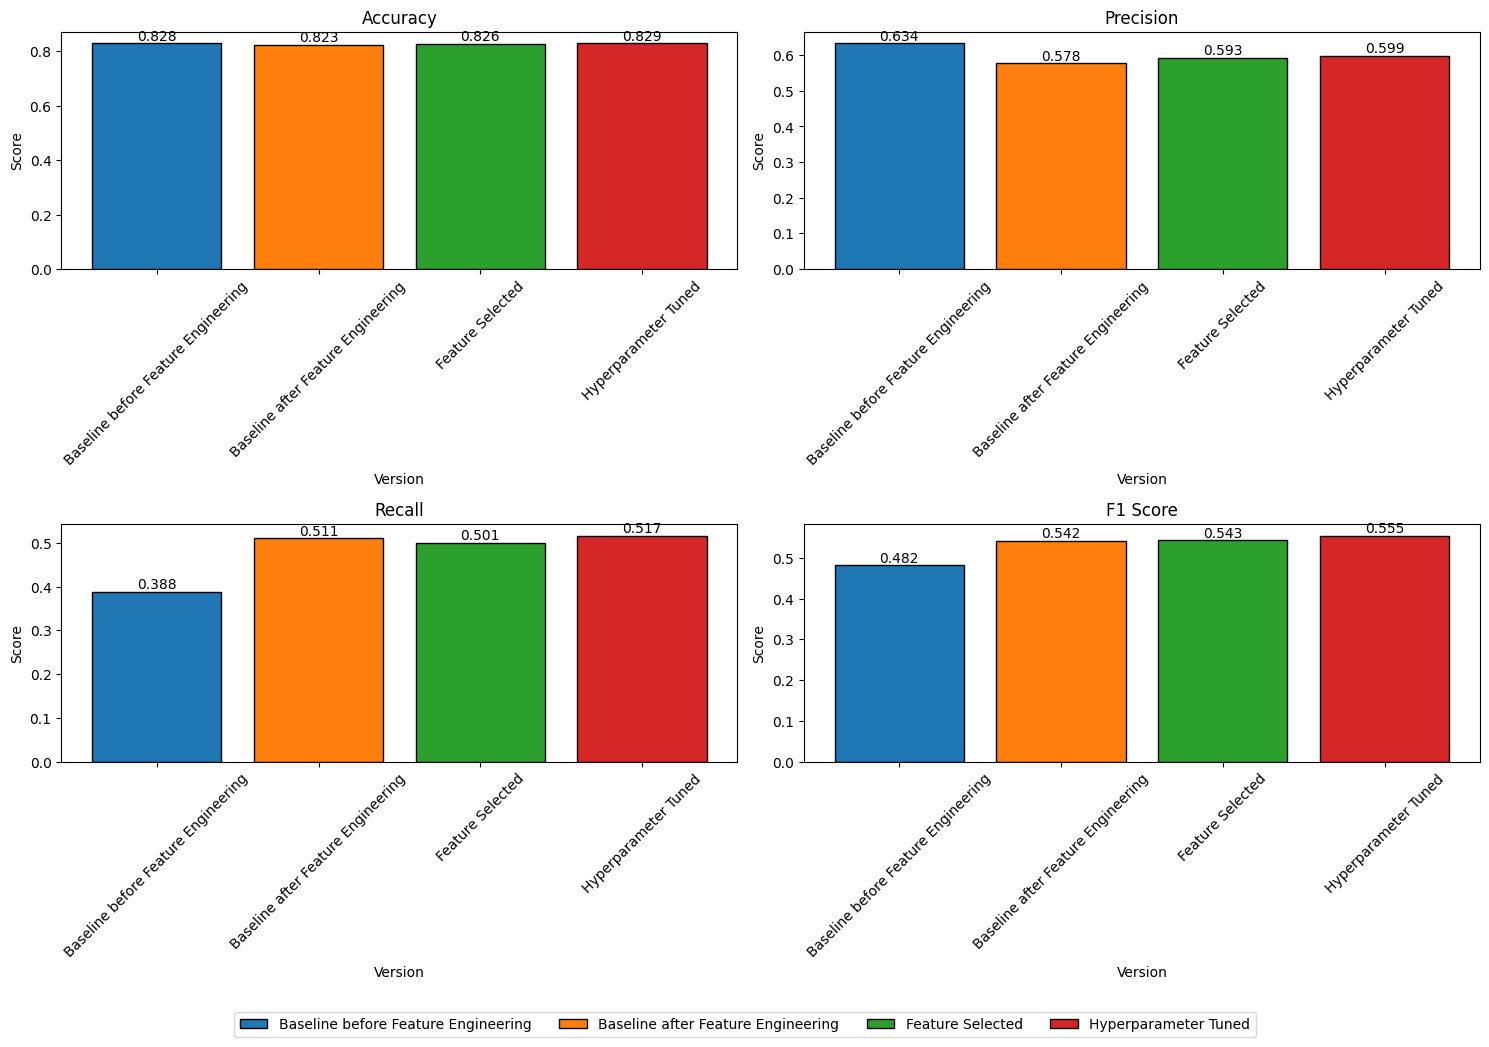

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

colormap = plt.cm.get_cmap('tab10')

for i, data in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    colors = colormap.colors[:len(test_metrics_lgbm['Version'])]
    for index, (model, value) in enumerate(zip(test_metrics_lgbm['Version'], test_metrics_lgbm[data])):
        axs[i].bar(model, value, color=colors[index], label=model if i == 0 else "", edgecolor='k')
    axs[i].set_title(data)
    axs[i].set_ylabel('Score')
    axs[i].set_xlabel('Version')
    axs[i].set_xticks(test_metrics_lgbm['Version'])
    axs[i].set_xticklabels(test_metrics_lgbm['Version'], rotation=45)
    for index, value in enumerate(test_metrics_lgbm[data]):
        axs[i].text(index, value, str(round(value, 3)), ha='center', va='bottom')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=len(test_metrics_lgbm['Version']))

plt.tight_layout()
plt.show()

## Export

In [16]:
# export the features used for this model
export_final_selected_features_to_csv(final_columns, "Best LightGBM")


Features exported successfully to FinalModels/Feature_Selection/Best LightGBM


In [17]:
# export the best model to be compared later on
joblib.dump(lgbm_tuned, "FinalModels/BestLightGBM.pkl")

['FinalModels/BestLightGBM.pkl']

## Alternative Method: Bayesian Optimization

Bayesian Optimization is a probabilistic model-based optimization technique used to find the maximum or minimum of an objective function over a bounded domain. It is particularly useful when the objective function is expensive to evaluate and noisy, as it aims to find the optimum with as few evaluations as possible. By iteratively updating the surrogate model and selecting the next sampling point based on the acquisition function, Bayesian Optimization efficiently explores the parameter space and converges to the optimal solution with a minimal number of evaluations of the objective function.

In [ ]:
from bayes_opt import BayesianOptimization
import lightgbm

In [ ]:
data = lightgbm.Dataset(X_train[final_columns], label=Y_train.values.ravel())

# Define the objective function
def objective_function(num_leaves, max_depth, learning_rate, min_split_gain, subsample, colsample_bytree):
    params = {'application':'binary', 'metric':'auc', 'verbose':-1}
    params['num_leaves'] = int(num_leaves)
    params["max_depth"] = int(max_depth)
    params['learning_rate'] = round(learning_rate, 2)
    params['min_split_gain'] = round(min_split_gain, 2)
    params['subsample'] = round(subsample, 2)
    params['colsample_bytree'] = round(colsample_bytree, 2)
    
    cv_result = lightgbm.cv(params, data, nfold=5, seed=47, stratified=True, metrics=['auc'])
    return max(cv_result['auc-mean'])

# Specify the search space
search_space = {
    'num_leaves': (20, 50),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 1),
    'min_split_gain': (0.1, 1),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

# Initialize the BayesianOptimization object
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=search_space,
    random_state=47  # Optional: set random seed for reproducibility
)

# Run the optimization
optimizer.maximize(
    init_points=10,  # Number of random exploration points
    n_iter=100,      # Number of optimization iterations
)

# Retrieve the best hyperparameters
best_hyperparams = optimizer.max['params']

|   iter    |  target   | colsam... | learni... | max_depth | min_sp... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9341    | 0.5567    | 0.9747    | 8.101     | 0.4163    | 41.23     | 0.8998    |
| 2         | 0.9418    | 0.8228    | 0.4205    | 7.942     | 0.322     | 27.68     | 0.512     |
| 3         | 0.9386    | 0.5494    | 0.3074    | 7.486     | 0.39      | 25.56     | 0.9586    |
| 4         | 0.9436    | 0.6355    | 0.2808    | 9.681     | 0.2144    | 42.42     | 0.5026    |
| 5         | 0.9361    | 0.9284    | 0.699     | 6.871     | 0.9417    | 35.38     | 0.5888    |
| 6         | 0.9236    | 0.7684    | 0.3005    | 3.074     | 0.8954    | 39.69     | 0.9711    |
| 7         | 0.9365    | 0.8725    | 0.2745    | 5.533     | 0.5738    | 36.41     | 0.6293    |
| 8         | 0.9252    | 0.5873    | 0.3671    | 3.981     | 0.4502    | 34.16     | 0.9844    |
| 9         | 0.937 

In [ ]:
best_hyperparams

{'colsample_bytree': 1.0,
 'learning_rate': 0.2509404266555085,
 'max_depth': 10.0,
 'min_split_gain': 0.1,
 'num_leaves': 40.87047583742487,
 'subsample': 0.5}